# 1 Imports

In [113]:
import pandas as pd
import sys
# from hurry.filesize import size
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import seaborn as sea
from datetime import datetime
from datetime import date
import datetime
from scipy.interpolate import interp1d

# 2 Load datasets from local files 

In [ ]:
cpd_df = pd.read_csv("Public_CPD_Arrests.csv")
r_cpd_df = cpd_df[18580:23980] #crime during track of covid data
# r_cpd_df = cpd_df #alternatively, use everything from the first record to the last
del(cpd_df) #conserve memory
cov_df = pd.read_csv("time_series_covid19_confirmed_US.csv")
r_cov_df = cov_df.loc[(cov_df['Province_State'] == 'Tennessee') & (cov_df['Admin2'] == 'Hamilton')] #covid data for Hamilton county, TN
del(cov_df) #conserve memory

# 3 Exploring CPD data 

Exploring the CPD arrests data is done, by default, with only the indexes that align with the Covid-19 data by start and end date. This is done so that any visualizations or statistics can be more accurately compared between the two, as they are measured over the same period.

## 3.1 Arrange dataframe with date timestamps as indexes and crimes as columns

This block creates the t_cpd_df dataframe, which conveniently prepares the data for plotting over a range of dates. However, plotting the dataframe outright is going to look pretty awful, so don't try it.

In [114]:
crime_dict_by_date = {} #perform tracking per date
# start = time.time() #performance measurement
# cnt = 0 #performance measurement

#23992 total for full dataset, 5400 total for covid-19 track only
for i,s in tqdm(r_cpd_df.iterrows(),total=5400,desc='CPD Arrest Data Rows',unit='rows'):
    date = s['Arrest Date'][:9].strip()
    charges = list(set(list(map(str.strip,s['Charges'].split(',')))))
    for c in charges:
        if date not in crime_dict_by_date: #date not present, add it and the first crime
            crime_dict_by_date[date] = {c:1}
            crime_dict_by_date[date]['TOTAL_DAILY_CRIMES'] = 1
        else: #date present
            if c not in crime_dict_by_date[date]: #crime sub-key not present, add crime sub-key
                crime_dict_by_date[date][c] = 1
                crime_dict_by_date[date]['TOTAL_DAILY_CRIMES'] += 1
            else: #crime sub-key present, increment crime sub-key
                crime_dict_by_date[date][c] += 1
                crime_dict_by_date[date]['TOTAL_DAILY_CRIMES'] += 1
#     cnt += 1

cpd_df = pd.DataFrame.from_dict(crime_dict_by_date)
cpd_df.fillna(0,inplace=True)
cpd_df.sort_values(by=['1/22/2020'],inplace=True,ascending=False)
cpd_df.drop(cpd_df.tail(1).index,inplace=True)
t_cpd_df = cpd_df.transpose()

t_cpd_df.reset_index(inplace=True)
t_cpd_df['index'] = pd.to_datetime(t_cpd_df['index']) #, errors='coerce' the errors parameter only applies when using full dataset
t_cpd_df.rename(columns={'index':'Date'},inplace=True)
t_cpd_df.set_index('Date',inplace=True)
t_cpd_df.index = t_cpd_df.index.map(datetime.date.toordinal) #converts from timestamp to date object
t_cpd_df.index = t_cpd_df.index.map(datetime.date.fromordinal)
t_cpd_df

CPD Arrest Data Rows: 100%|███████████████████████████████████████████████████| 5400/5400 [00:00<00:00, 10188.62rows/s]


,TOTAL_DAILY_CRIMES,Serving Warrant,Drug Equipment Violation,Drugs/Narcotics Violation/Felony,All Other Traffic Offenses,Miscellaneous,Other,Trespass of Real Property,Aggravated Assault,Disorderly Conduct,...,Forcible Rape,Simple Assault/DV,Theft & Recovery/Passenger Vehicle,Statutory Rape,Liquor Law Violation,Gambling Equipment Violation,Counterfeiting/Forgery,MVT/Motorcycle,Violation of Protection Order,Damaged Property Accidental
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,51.0,10.0,10.0,7.0,4.0,4.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,43.0,4.0,9.0,11.0,2.0,1.0,1.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,19.0,6.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,28.0,2.0,3.0,1.0,2.0,3.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,66.0,3.0,5.0,4.0,4.0,7.0,4.0,3.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-11,40.0,6.0,3.0,3.0,0.0,5.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-09-12,44.0,8.0,2.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-09-13,23.0,5.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
t_cpd_df.index[0]

## 3.2 Explore CPD data with statistics

### 3.2.1 Explore by crime

The data is normally formatted for plotting, so getting descriptive statistics from it requires the replacement of all zeroes with NaNs. This is done on a copy, so the later plotting code blocks are unaffected by this.

In [115]:
cpy = t_cpd_df.copy(deep=True)
cpy.replace(0,np.nan,inplace=True)
cpy.describe()

,TOTAL_DAILY_CRIMES,Serving Warrant,Drug Equipment Violation,Drugs/Narcotics Violation/Felony,All Other Traffic Offenses,Miscellaneous,Other,Trespass of Real Property,Aggravated Assault,Disorderly Conduct,...,Forcible Rape,Simple Assault/DV,Theft & Recovery/Passenger Vehicle,Statutory Rape,Liquor Law Violation,Gambling Equipment Violation,Counterfeiting/Forgery,MVT/Motorcycle,Violation of Protection Order,Damaged Property Accidental
count,238.000000,221.000000,203.000000,196.000000,175.000000,189.000000,168.000000,172.000000,97.000000,167.000000,...,1.0,10.000000,7.000000,1.0,4.0,1.0,17.0,7.000000,52.000000,1.0
mean,31.470588,4.280543,3.330049,2.887755,2.120000,2.354497,1.833333,2.087209,1.371134,1.952096,...,1.0,1.200000,1.142857,1.0,1.0,1.0,1.0,1.428571,1.250000,1.0
std,12.282074,2.470376,2.321751,2.042536,1.331493,1.482610,1.087031,1.227587,0.949995,1.417653,...,NaN,0.421637,0.377964,NaN,0.0,NaN,0.0,0.786796,0.519238,NaN
min,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0
25%,23.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0
50%,30.000000,4.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0
75%,39.000000,6.000000,4.000000,4.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.500000,1.000000,1.0
max,72.000000,12.000000,11.000000,11.000000,7.000000,7.000000,8.000000,9.000000,9.000000,11.000000,...,1.0,2.000000,2.000000,1.0,1.0,1.0,1.0,3.000000,3.000000,1.0


It is also possible to explore the data by specific crimes.

In [ ]:
cpy['TOTAL_DAILY_CRIMES'].describe()

In the code block below, you can pick which crime you'd like to learn more about. The code will show you all results that contain the term you enter, so entering "burg" will return all results related to burglary, while "a" will likely return most if not all the crimes, given that their names include the letter "a." Keep in mind that these are not the measurements of that crime on specific days, but rather across all days from Jan 22, 2020 to Sep 15, 2020.

In [116]:
crimes = t_cpd_df.columns
hlp = '/c\tList out available crimes to search.\n-------------------------------------------\n'
print(hlp)

term = input('Search for: ')

if term == '/c':
    for index,crime in enumerate(crimes):
        print('{}\t{}'.format(index+1,crime))
    exit
else:
    matches = []
    for crime in crimes:
        if term.lower() in crime.lower(): matches.append(crime)
        else: continue
    if not matches:
        print('There were no results. Try again.')
        exit
    else:
        for match in matches:
#             print(cpy[match].describe())
            display(cpy[match].describe())
#             print('\n\n')

/c	List out available crimes to search.
-------------------------------------------

Search for: burg


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: 220   BURGLARY/BREAKING AND ENTERING, dtype: float64

count    9.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: Burglary/Non-residential, dtype: float64

count    9.000000
mean     1.111111
std      0.333333
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      2.000000
Name: Burglary/DV, dtype: float64

count    38.000000
mean      1.289474
std       0.693908
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       4.000000
Name: Burglary/Residential, dtype: float64

count    26.000000
mean      1.192308
std       0.401918
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: Burglary/Business, dtype: float64

### 3.2.2 Explore by time period

The original t_cpd_df dataframe is used here.

You can search for a specific range of values across the given time frame.

In [117]:
print('Enter your chosen month, day, and year to search. Use M-D-Y format. Do not preface values with 0.\n\nThe available timeframe is from {} to {}'.format(str(t_cpd_df.index[0]),str(t_cpd_df.index[-1])))
start = input('Starting date: ')
end = input('Ending date: ')

start_list = start.split('-')
end_list = end.split('-')

start = datetime.date(int(start_list[2]),int(start_list[0]),int(start_list[1]))
end = datetime.date(int(end_list[2]),int(end_list[0]),int(end_list[1]))

print('Choose to show dataframe view or statistical view. Enter DF for dataframe and ST for statistics.')
op = input('Choice: ')
if op == 'DF': display(t_cpd_df[start:end])
elif op == 'ST': display(t_cpd_df[start:end].describe())
else:
    print('Unrecognized choice. Defaulting to dataframe.')
    display(t_cpd_df[start:end])

Enter your chosen month, day, and year to search. Use M-D-Y format. Do not preface values with 0.

The available timeframe is from 2020-01-22 to 2020-09-15
Starting date: 2-24-2020
Ending date: 5-13-2020
Choose to show dataframe view or statistical view. Enter DF for dataframe and ST for statistics.
Choice: ST


,TOTAL_DAILY_CRIMES,Serving Warrant,Drug Equipment Violation,Drugs/Narcotics Violation/Felony,All Other Traffic Offenses,Miscellaneous,Other,Trespass of Real Property,Aggravated Assault,Disorderly Conduct,...,Forcible Rape,Simple Assault/DV,Theft & Recovery/Passenger Vehicle,Statutory Rape,Liquor Law Violation,Gambling Equipment Violation,Counterfeiting/Forgery,MVT/Motorcycle,Violation of Protection Order,Damaged Property Accidental
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,...,80.0,80.000000,80.000000,80.0,80.0,80.0,80.000000,80.000000,80.000000,80.0
mean,28.600000,3.162500,2.950000,2.412500,1.387500,1.787500,1.00000,1.487500,0.512500,1.112500,...,0.0,0.037500,0.037500,0.0,0.0,0.0,0.100000,0.037500,0.125000,0.0
std,12.508832,2.528039,2.671462,2.293048,1.277792,1.658837,1.01881,1.542592,0.762968,1.179935,...,0.0,0.248731,0.248731,0.0,0.0,0.0,0.301893,0.248731,0.368885,0.0
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
25%,19.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
50%,26.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
75%,36.000000,4.000000,4.000000,3.250000,2.000000,3.000000,2.00000,2.000000,1.000000,2.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
max,64.000000,12.000000,11.000000,8.000000,6.000000,7.000000,6.00000,9.000000,3.000000,6.000000,...,0.0,2.000000,2.000000,0.0,0.0,0.0,1.000000,2.000000,2.000000,0.0


## 3.3 Explore data through visualization

### 3.3.1 Trendlines

The two code blocks below will show trendlines for each crime, as well as the scatterplot upon which that trendline is drawn. Two versions are provided, one that is faster at the expense of using more RAM, and vice versa.

NOTE: Interrupting the kernel during execution of either of these plotting operations, or if an error is encountered for some reason, is likely to cause some unwanted variable changes to linger around in the environment. Reset the t_cpd_df dataframe by running its setup block again in order to fix this problem.

#### 3.3.1a Make plots for crimes (Faster, RAM intensive)

If you interrupt the kernel to stop this cell's execution before it has finished, you will likely need to run the code above here that rebuilds the t_cpd_df dataframe. I do not know exactly why interrupting the kernel breaks future attempts at running this cell, but it does.

This cell will create a trendline to visualize the change in specific crimes during the period from Jan 22 2020 to Sep 15 2020. Date values are displayed in their ordinal form, meaning one shouldn't base monthly observations off these graphs. Rather, this is useful for getting an idea of how arrests for these particular crimes changed over time.

CPD Scatterplots with Trendlines: 100%|███████████████████████████████████████████| 98/98 [00:14<00:00,  6.65figures/s]


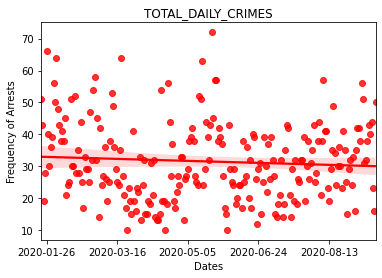

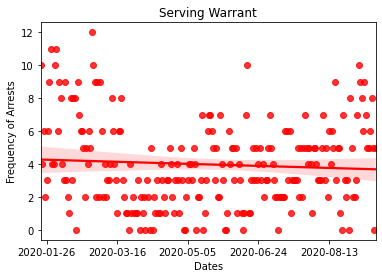

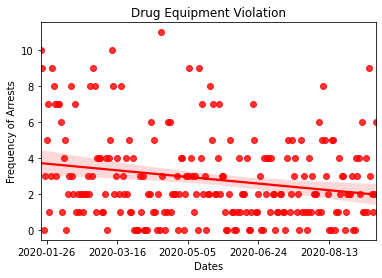

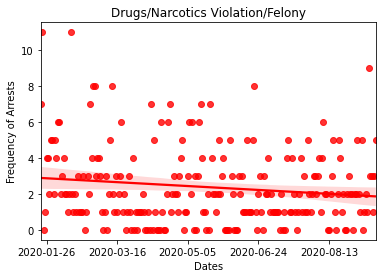

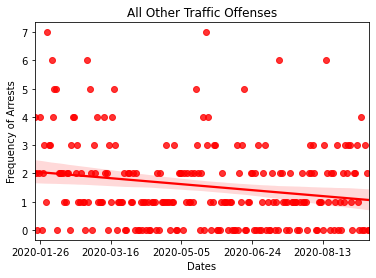

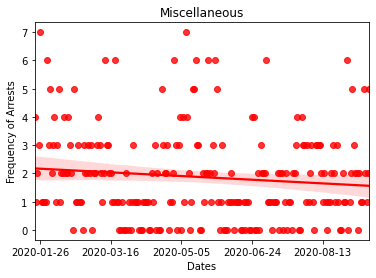

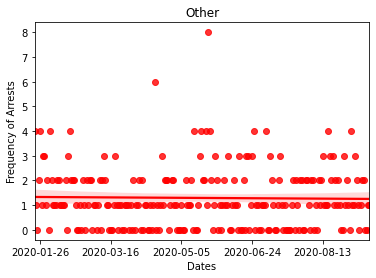

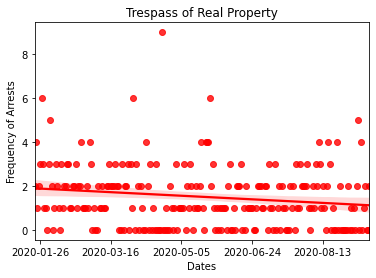

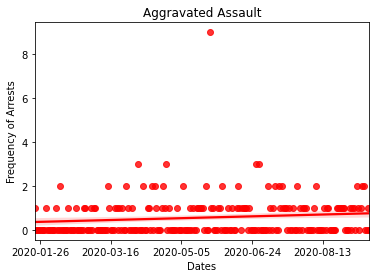

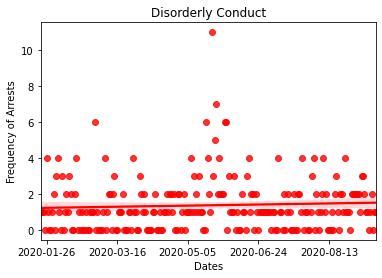

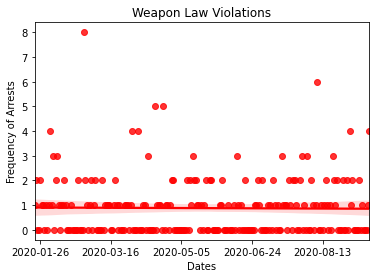

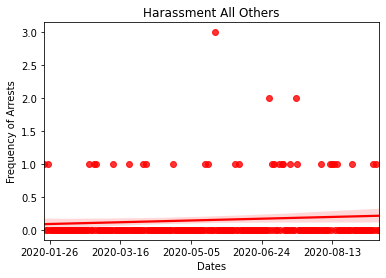

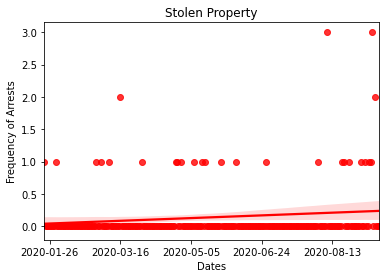

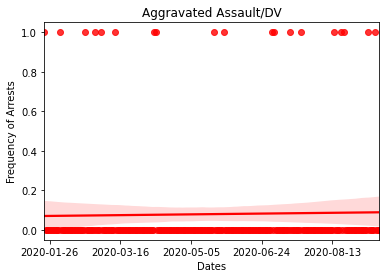

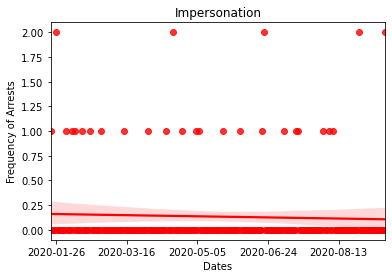

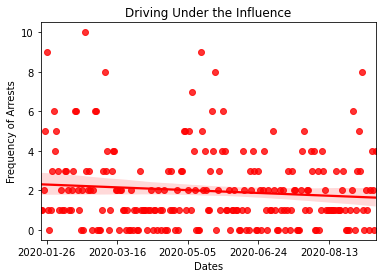

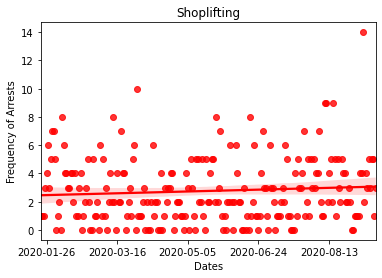

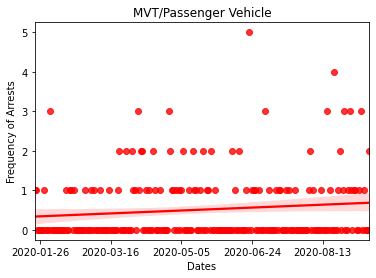

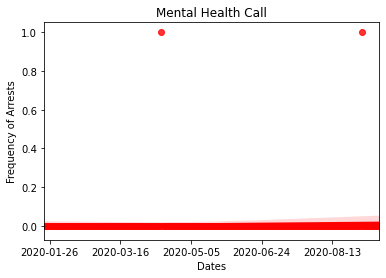

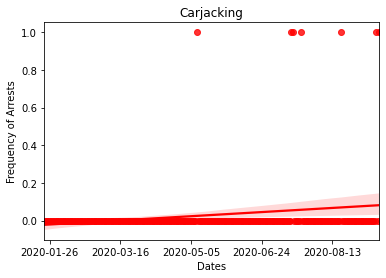

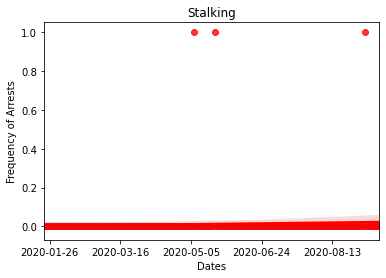

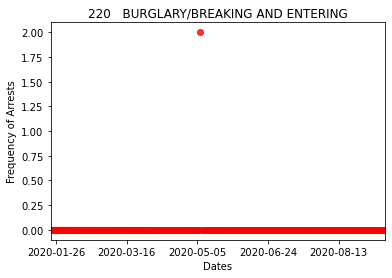

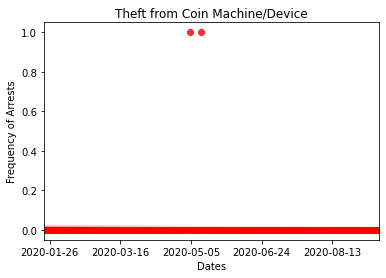

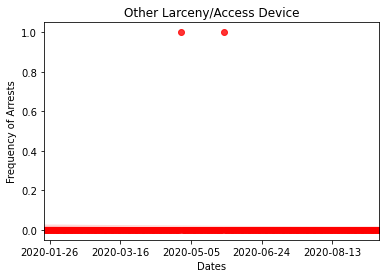

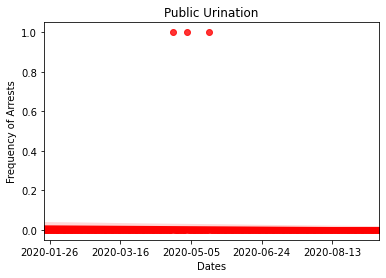

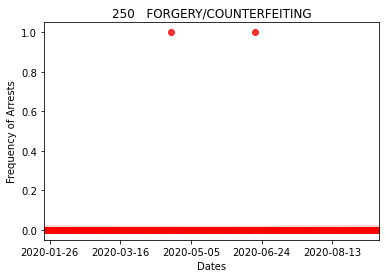

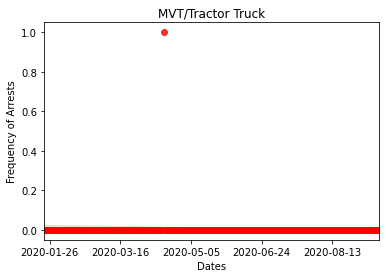

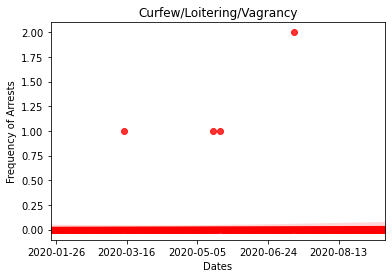

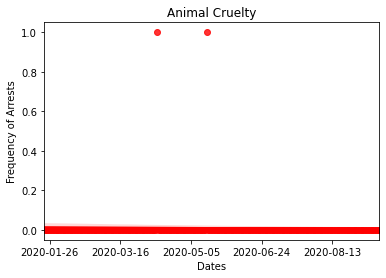

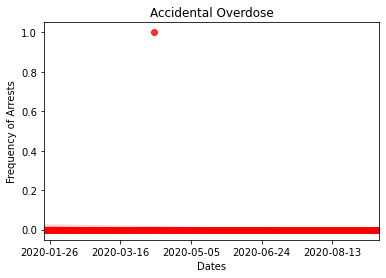

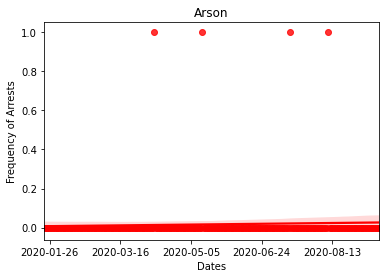

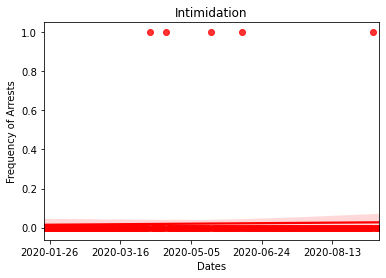

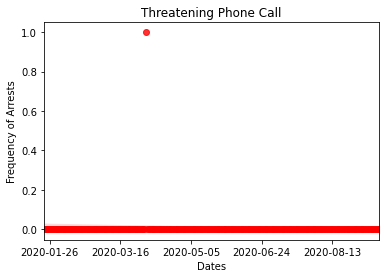

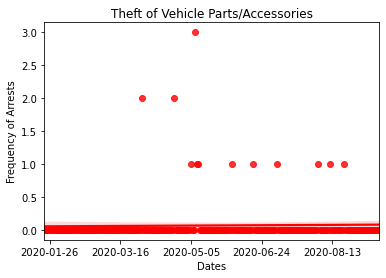

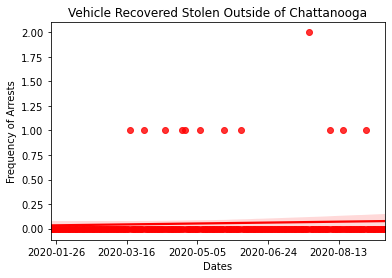

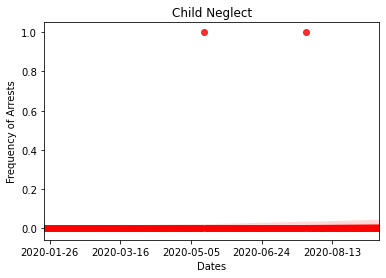

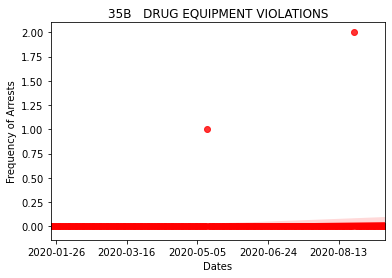

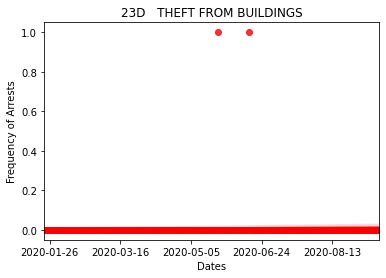

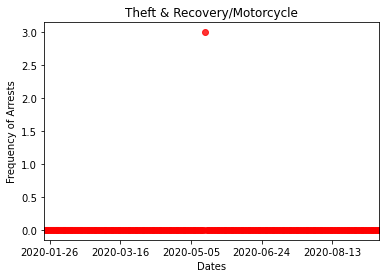

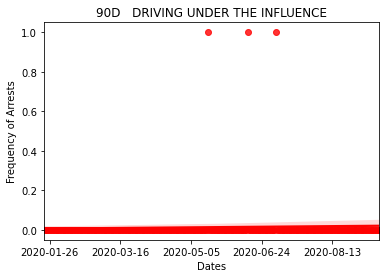

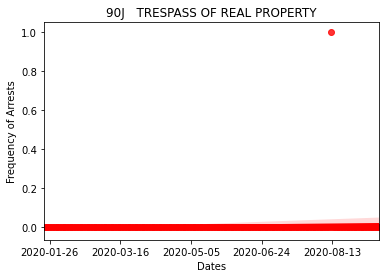

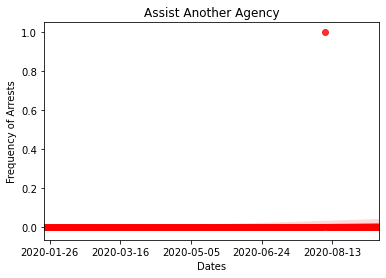

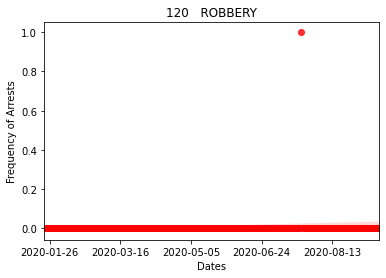

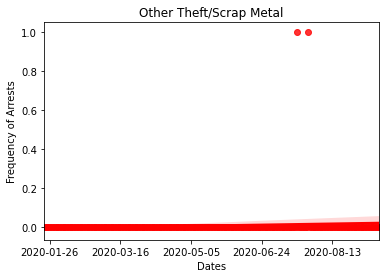

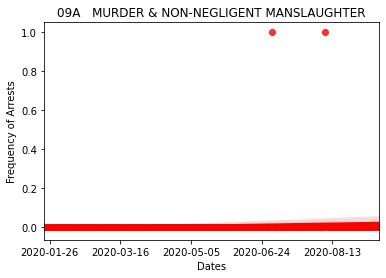

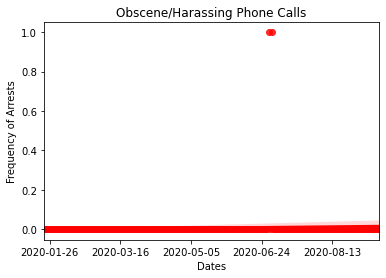

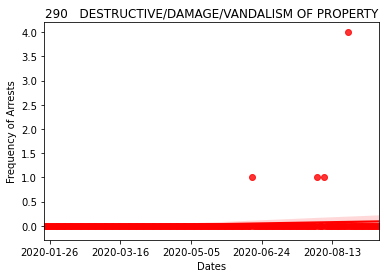

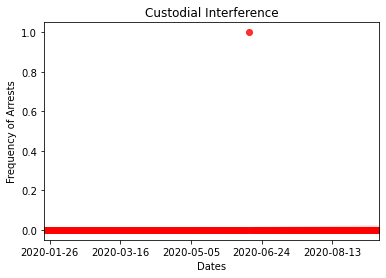

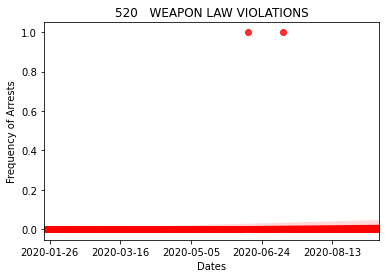

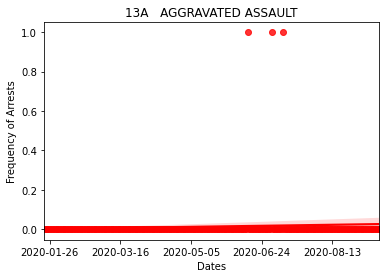

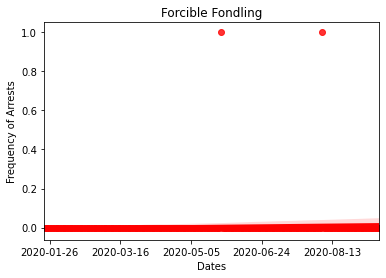

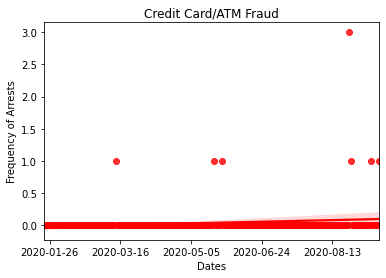

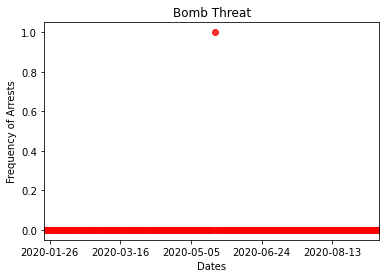

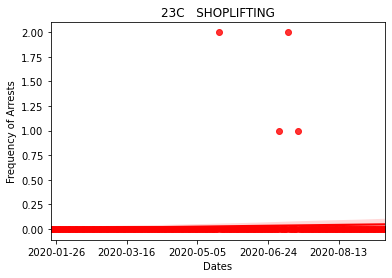

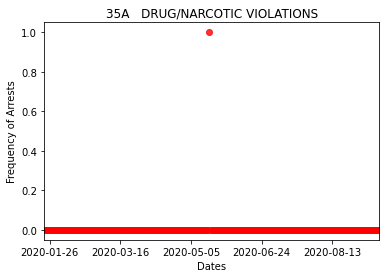

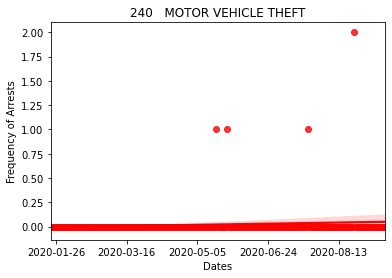

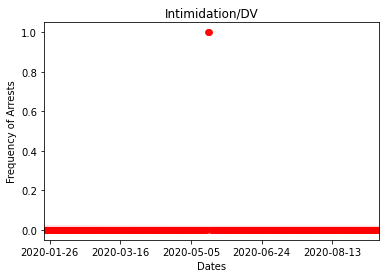

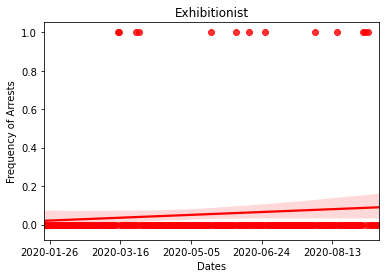

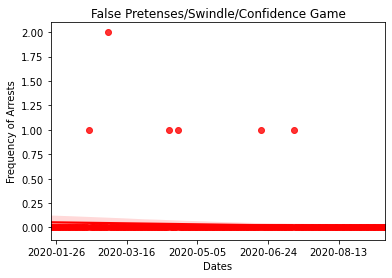

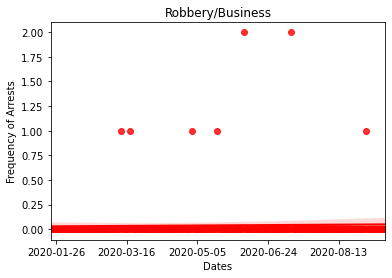

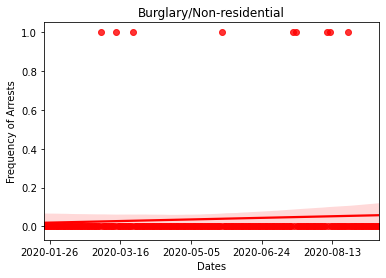

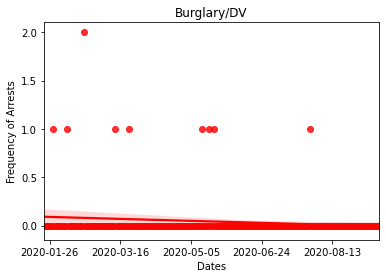

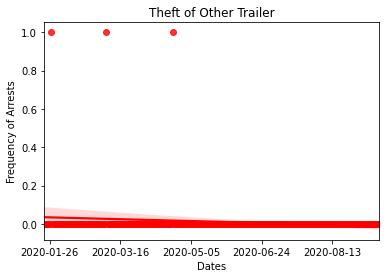

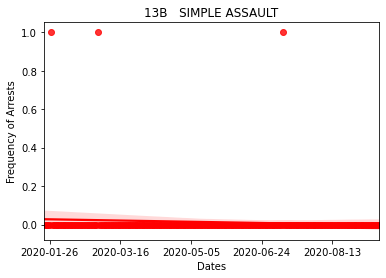

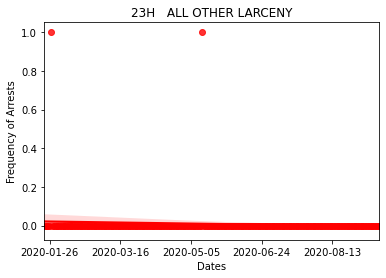

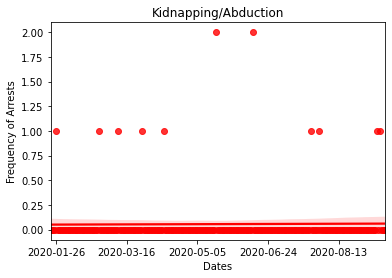

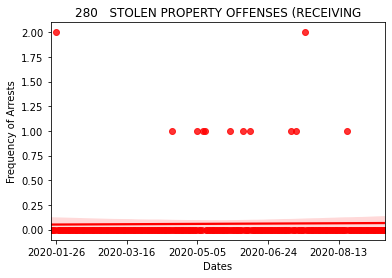

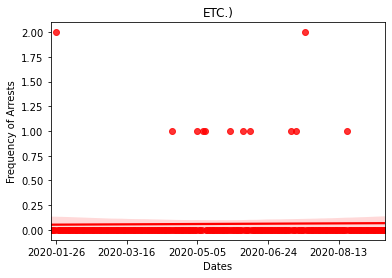

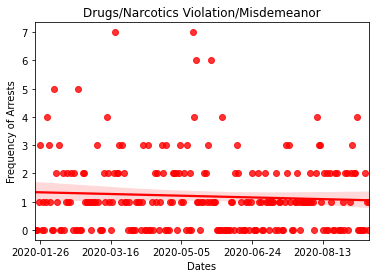

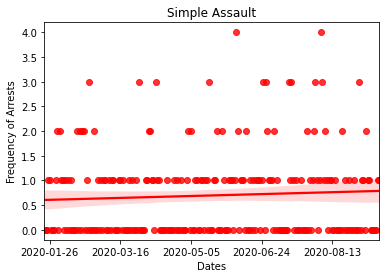

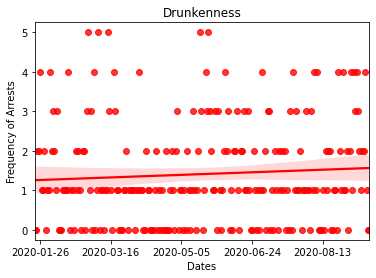

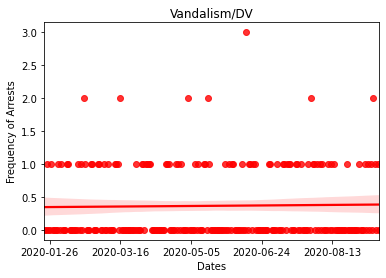

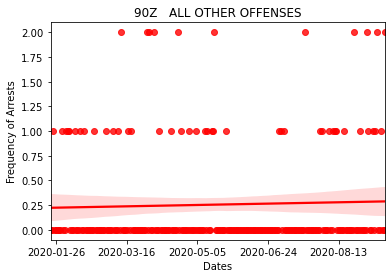

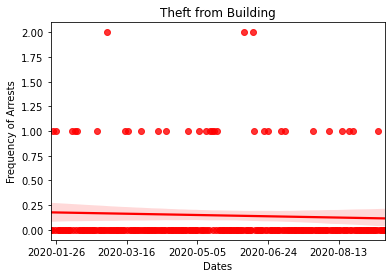

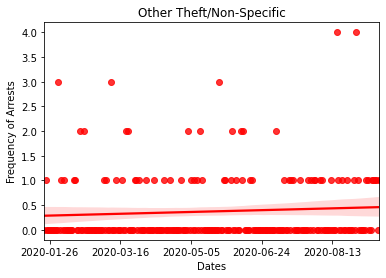

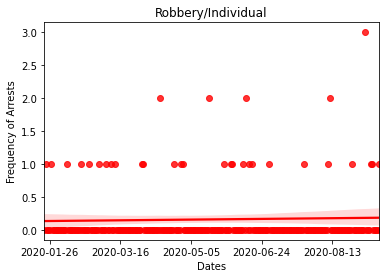

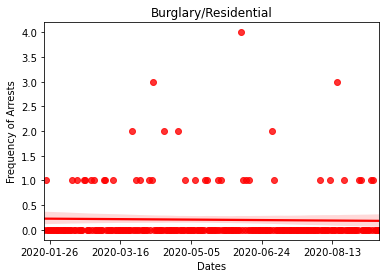

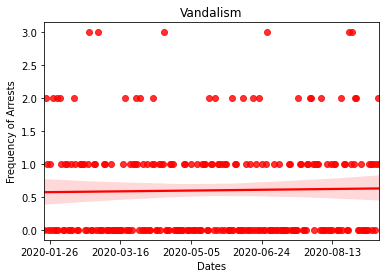

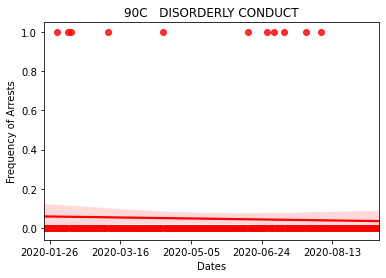

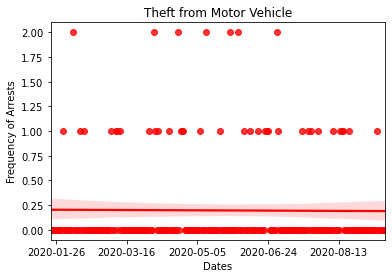

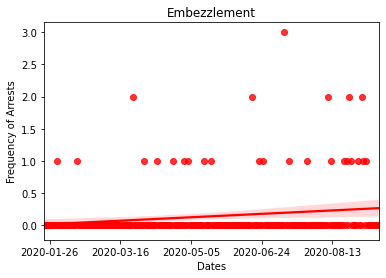

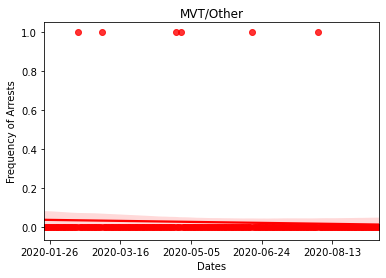

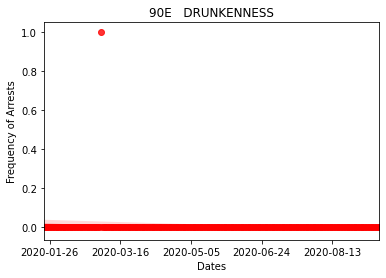

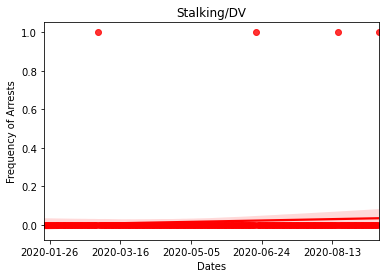

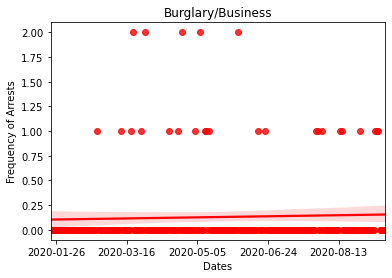

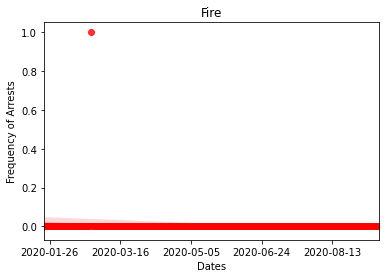

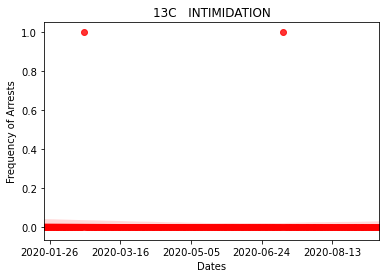

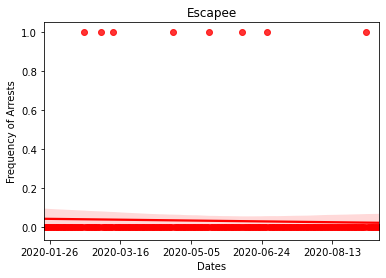

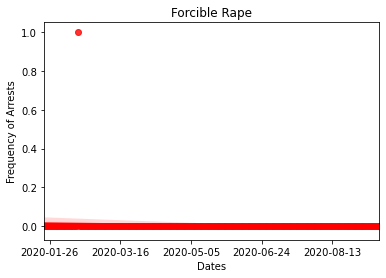

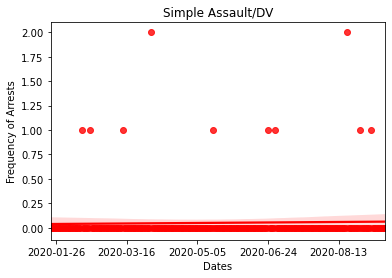

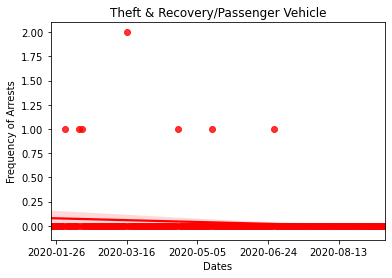

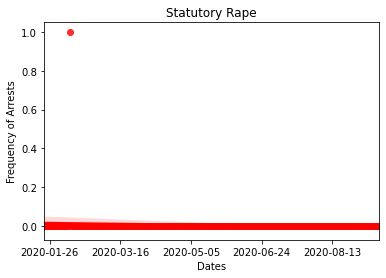

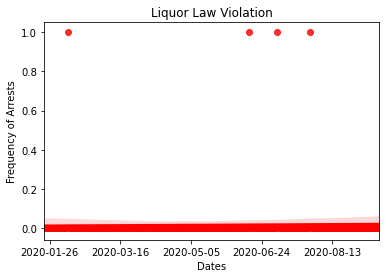

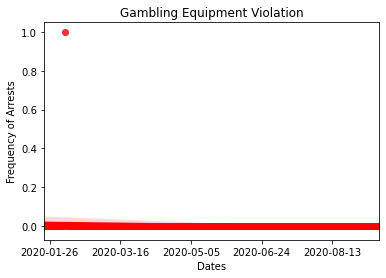

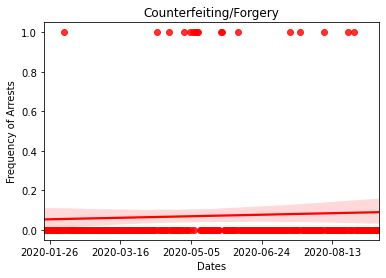

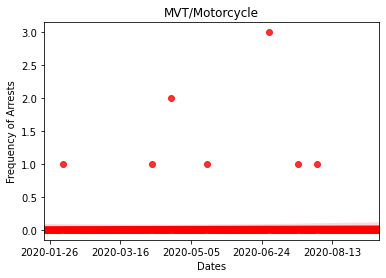

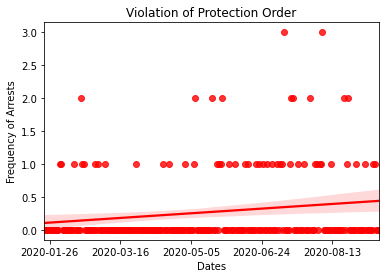

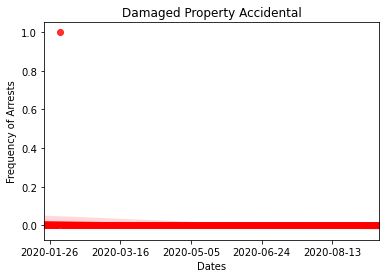

In [118]:
plt.rcParams.update({'figure.max_open_warning': 0})
t = len(t_cpd_df.columns)
x = 'Dates'
y = 'Frequency of Arrests'
t_cpd_df.index = t_cpd_df.index.map(datetime.date.toordinal)

for col in tqdm(t_cpd_df,total=t,desc='CPD Scatterplots with Trendlines',unit='figures'):
    plt.figure()
    s = sea.regplot(t_cpd_df.index,t_cpd_df[col],data=t_cpd_df,color='Red')
    ax = plt.gca()
    xticks = ax.get_xticks()
    xticks_dates = [datetime.date.fromordinal(int(x)) for x in xticks]
    ax.set_xticklabels(xticks_dates)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(col)

t_cpd_df.index = t_cpd_df.index.map(datetime.date.fromordinal)
plt.show()
plt.close('all') #close all figures to prevent memory leak

In [ ]:
print(t_cpd_df.index[0])
print(type(t_cpd_df.index[0]))

In [ ]:
t_cpd_df

#### 3.3.1b Make plots for crimes (Slower, easier on RAM)

This doesn't load all figures into memory at once. It continually writes on the same figure while putting new ones in the output. Use this if you have very low RAM (8>=).

This serves the same purpose and has the same limitations as the previous plotting cell. Additionally, this cell suffers from the same problems if you interrupt its execution partway through.

In [ ]:
t_cpd_df.index = t_cpd_df.index.map(datetime.date.toordinal)
plt.figure()
x = 'Dates'
y = 'Frequency of Arrests'

for col in t_cpd_df:
    sea.regplot(t_cpd_df.index,t_cpd_df[col],data=t_cpd_df,color='Red')
    ax = plt.gca()
    xticks = ax.get_xticks()
    xticks_dates = [datetime.date.fromordinal(int(x)) for x in xticks]
    ax.set_xticklabels(xticks_dates)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(col)
    plt.show()

t_cpd_df.index = t_cpd_df.index.map(datetime.date.fromordinal)

In [ ]:
t_cpd_df

### 3.3.2 Line plot of CPD data

Normally, the plot of the CPD data is very angular and hard to look at, even when broken down into individual crime plots. With some interpolation, it can be smoothed out a bit to make viewing slightly less painful.

The line plots will be made with a copy of the t_cpd_df dataframe to avoid any changes to the original.

In [112]:
f1 = interp1d(t_cpd_df.index, t_cpd_df['TOTAL_DAILY_CRIMES'],kind='cubic')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Plot of Covid-19 data

In [ ]:
cov_df = r_cov_df.loc[:,'1/22/2020':]
t_cov_df = cov_df.transpose()
t_cov_df.rename(columns={t_cov_df.columns[0]:'Cases'}, inplace=True)
# t_cov_df.cumsum()
plt.figure()
t_cov_df.plot()
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Hamilton County Covid Cases')
plt.show()